# Age and Gender recognition with OpenVINO
This tutorial demonstrates age and gender recognition using age-gender-recognition-retail-0013 model of OpenVino toolkit. The model used is a fully convolution network which is designed for simultaneous age and gender recognition. Images of people ranging in age from 18 to 75 years old were used to train the model.

## Preparation

### Importing Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cv2
import tensorflow as tf
from openvino.runtime import Core
from pathlib import Path
from PIL import Image
import matplotlib.image as mpimg

import sys
sys.path.append("../utils")

## Set the device type, model path and model name

In [2]:
# Device to use for inference. For example, "CPU", or "GPU"
DEVICE = "CPU"

# Model file path and model name
model_name = "age-gender-recognition-retail-0013"
precision = "FP32"
model_xml_path = 'model/age-gender-recognition-retail-0013.xml' 
model_bin_path = 'model/age-gender-recognition-retail-0013.bin' # this path contains the weights

print(f"Model name: {model_name}")
print(f"Model XML file path: {model_xml_path}")

Model name: age-gender-recognition-retail-0013
Model XML file path: model/age-gender-recognition-retail-0013.xml


## Loading the Age and gender detection model
Load and compile the age and gender detection model with ie.read_model and ie.compile_model functions, respectively.  Get input and output keys and the expected input shape for the model.

In [3]:
ie = Core()
model = ie.read_model(model=model_xml_path, weights=model_bin_path)
compiled_model = ie.compile_model(model=model, device_name=DEVICE)

# The input key contains information and shape of the model input

input_key = compiled_model.inputs[0]
print(input_key)

# The output key contains information and shape of the model output
output_key = compiled_model.outputs
print(output_key)

<ConstOutput: names[data] shape{1,3,62,62} type: f32>
[<ConstOutput: names[prob] shape{1,2,1,1} type: f32>, <ConstOutput: names[fc3_a, age_conv3] shape{1,1,1,1} type: f32>]


#### Storing output keys of age and gender in seperate variables 

In [4]:
output_key_gender = compiled_model.outputs[0]
print(output_key_gender)
output_key_age = compiled_model.outputs[1]
print(output_key_age)

<ConstOutput: names[prob] shape{1,2,1,1} type: f32>
<ConstOutput: names[fc3_a, age_conv3] shape{1,1,1,1} type: f32>


#### Input shape of the model

In [5]:
network_input_shape = list(input_key.shape)
print(network_input_shape)

[1, 3, 62, 62]


In [6]:
input_width = 62
input_height = 62
print(f"The network expects input image with a width of {input_width}, " f"height of {input_height}")
print("And the network returns age and gender of the person in the image")

The network expects input image with a width of 62, height of 62
And the network returns age and gender of the person in the image


## Load Image And Prepare For Inference

Since the model expects color order BGR so let's define a function for changing the color order of the input image. Also the input dimensions of the model are fixed so we will need to resize the image to match the input dimensions. 

In [7]:
def resize_image(data):
    image = cv2.cvtColor(cv2.imread(data), code=cv2.COLOR_RGB2BGR) # loads and converts RGB image to BGR image
    input_image = cv2.resize(src=image, dsize=(62, 62)) # Resize image to meet network expected input sizes
    return input_image

In [8]:
input_image_directory = 'data/image1.jpg'
input_image = resize_image(input_image_directory)
print(input_image.shape)

(62, 62, 3)


In [9]:
# Reshape to network input shape
input_image = np.expand_dims(np.transpose(input_image, (2, 0, 1)), 0)
input_image.shape

(1, 3, 62, 62)

## Do inference on the input image
Run the model on the input image to get the Age and Gender for the image. 

In [10]:
result_infer_age = compiled_model(inputs=[input_image])[output_key_age]
result_infer_gender = compiled_model(inputs=[input_image])[output_key_gender]

In [11]:
print(result_infer_age) #this contains age/100 as output
print(result_infer_gender) #this is a softmax output

[[[[0.27364206]]]]
[[[[0.01580241]]

  [[0.98419756]]]]


### Converting the output into more interpretable format

In [12]:
result_gender = [result_infer_gender[0][0][0][0], result_infer_gender[0][1][0][0]]
age = round(result_infer_age[0][0][0][0]*100)
gender_list = ['female', 'male']
gender = gender_list[np.around(result_gender, decimals=0).argmax(axis=0)]

### Display image the age-gender corresponding to it

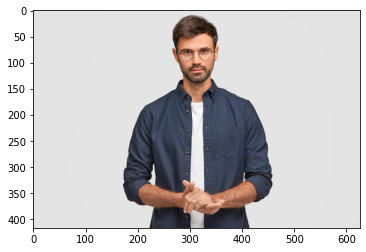

27
male


In [13]:
input_img = mpimg.imread(input_image_directory)
imgplot = plt.imshow(input_img)
plt.show()
print(age)
print(gender)